C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [16:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH1.csv
Mean Squared Error (MSE): 0.4271687635886554
Mean Absolute Error (MAE): 0.5655202001365837
R-squared (R²): -1.8698068781070254


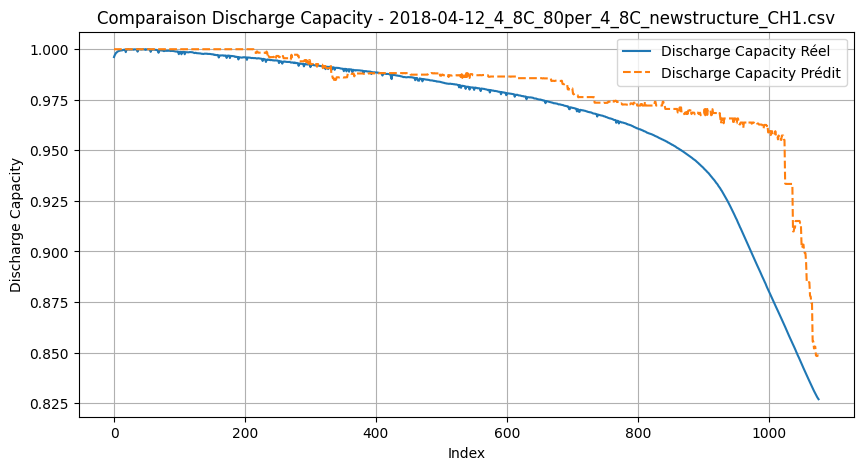

Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH17.csv
Mean Squared Error (MSE): 0.42746925484002124
Mean Absolute Error (MAE): 0.5644691586608674
R-squared (R²): -1.9139430810753582


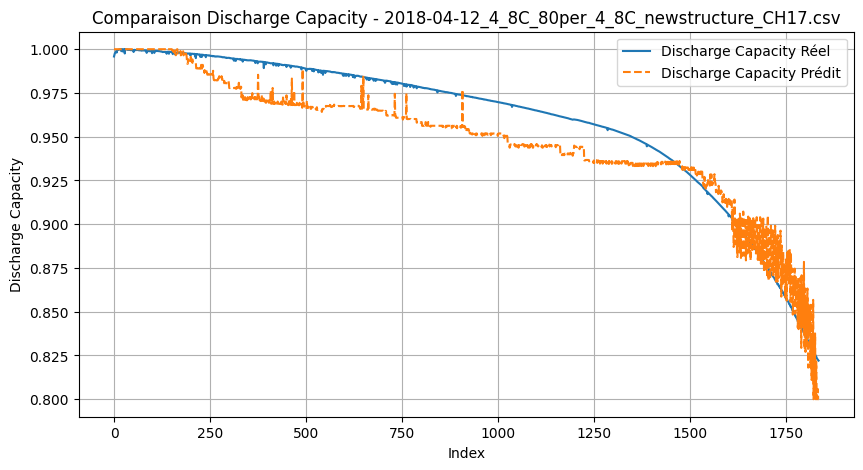

Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH25.csv
Mean Squared Error (MSE): 0.43264214894116076
Mean Absolute Error (MAE): 0.5723622707837417
R-squared (R²): -2.0481877534275807


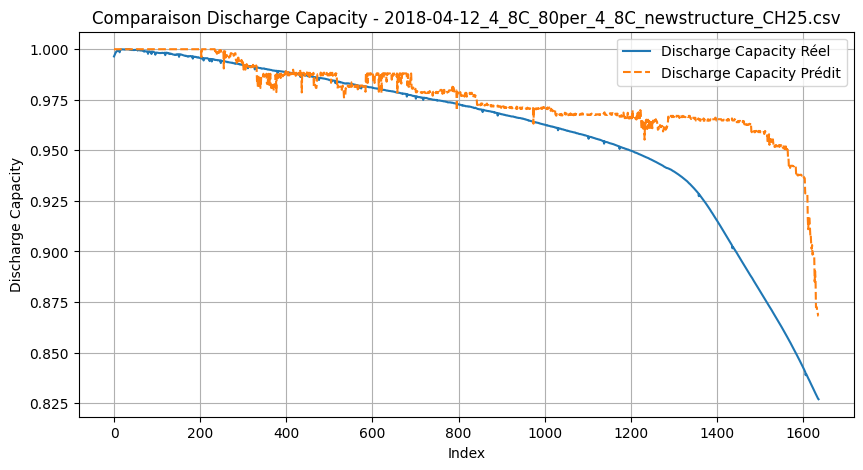

Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH9.csv
Mean Squared Error (MSE): 0.4317634307769419
Mean Absolute Error (MAE): 0.5703457502665936
R-squared (R²): -2.0381596686800725


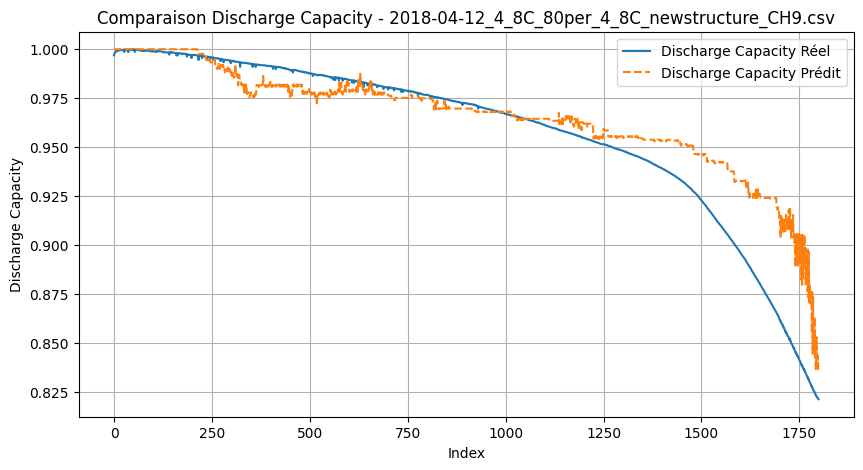

In [2]:
import os
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Chemin vers le répertoire contenant les fichiers CSV
data_path = r'C:\\Users\\pc\\Desktop\\data\\all batchs'

# Lister tous les fichiers CSV dans le répertoire donné
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Sélectionner les fichiers pour l'entraînement et le test
train_files = csv_files[:12]  # Les 12 premiers fichiers pour l'entraînement
test_files = csv_files[12:]   # Les 5 derniers fichiers pour le test

# Initialiser les ensembles de données d'entraînement
X_train_total = []
y_train_total = []

# Préparer les données d'entraînement
for csv_file in train_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    X = df.drop(columns=['Discharge_Capacity'])
    y = df['Discharge_Capacity']
    X_train_total.append(X)
    y_train_total.append(y)

# Concaténer les données d'entraînement
X_train = pd.concat(X_train_total, axis=0)
y_train = pd.concat(y_train_total, axis=0)

# Convertir en matrices DMatrix de XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Définir les paramètres du modèle
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 6,
    'alpha': 10,
    'n_estimators': 100
}

# Entraîner le modèle
model_xgb = xgb.train(params, dtrain, num_boost_round=100)
model_path='C:\\Users\\pc\\Desktop\\PHM-BATTERIES\\Models\\xgb.json'
model_xgb.save_model(model_path)
# Tester le modèle sur chaque fichier de test
for csv_file in test_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    X_test = df.drop(columns=['Discharge_Capacity'])
    y_test = df['Discharge_Capacity']
    
    # Convertir en matrice DMatrix de XGBoost
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Faire des prédictions
    xgb_pred = model_xgb.predict(dtest)
    
    # Limiter les prédictions entre 0 et 1
    xgb_pred = np.clip(xgb_pred, 0.8, 1)
    
    # Convertir y_test en DataFrame pour aligner les indices
    y_test_df = pd.DataFrame(y_test).reset_index(drop=True)

    # Calculer les métriques
    mse = mean_squared_error(y_test_df, xgb_pred)
    mae = mean_absolute_error(y_test_df, xgb_pred)
    r2 = r2_score(y_test_df, xgb_pred)

    # Afficher les résultats
    print(f"Fichier de test: {csv_file}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")
    
    cycle_index = df['Cycle_Index']
    
    xgb_pred_max_per_cycle = pd.Series(xgb_pred).groupby(cycle_index).max()
    y_test_max_per_cycle = y_test.groupby(cycle_index).max()
    
    # Tracer le graphique pour comparer les valeurs réelles et prédites
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_max_per_cycle, label='Discharge Capacity Réel')
    plt.plot(xgb_pred_max_per_cycle, label='Discharge Capacity Prédit', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Discharge Capacity')
    plt.title(f'Comparaison Discharge Capacity - {csv_file}')
    plt.legend()
    plt.grid(True)
    plt.show()


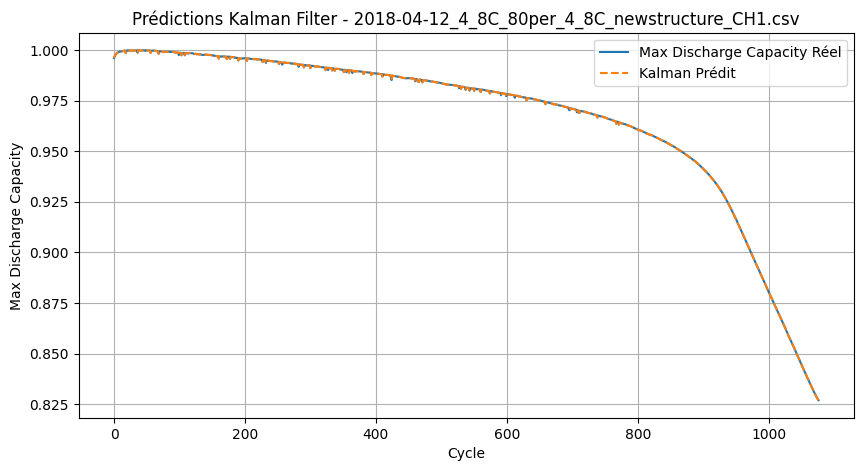

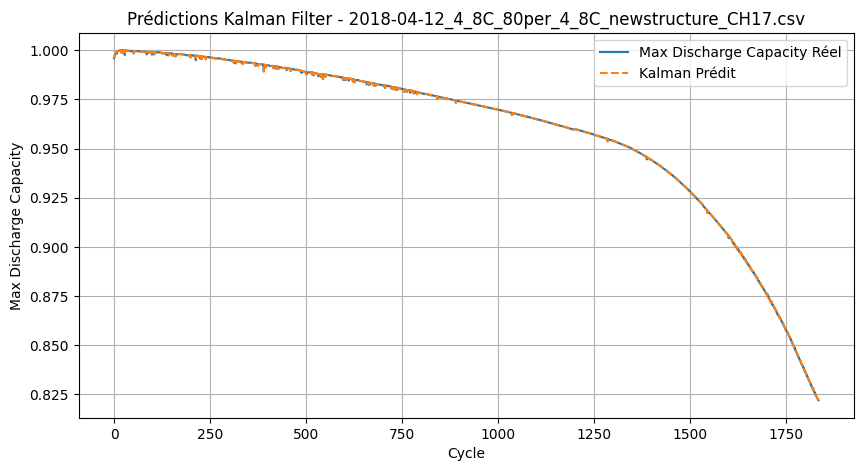

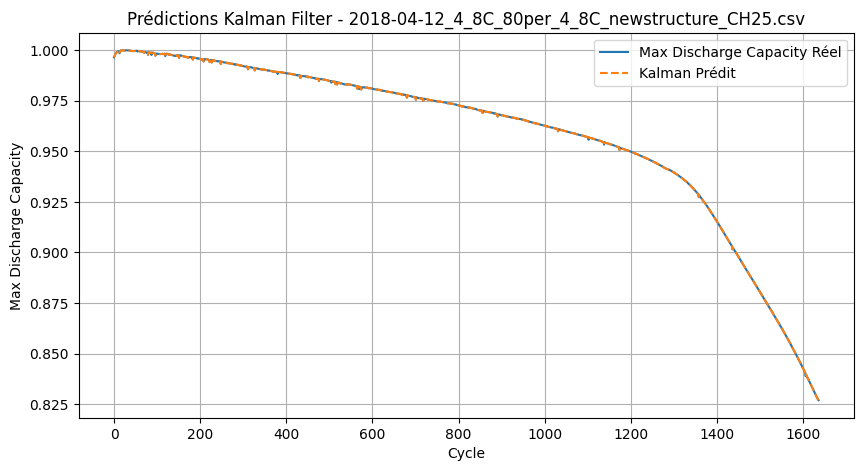

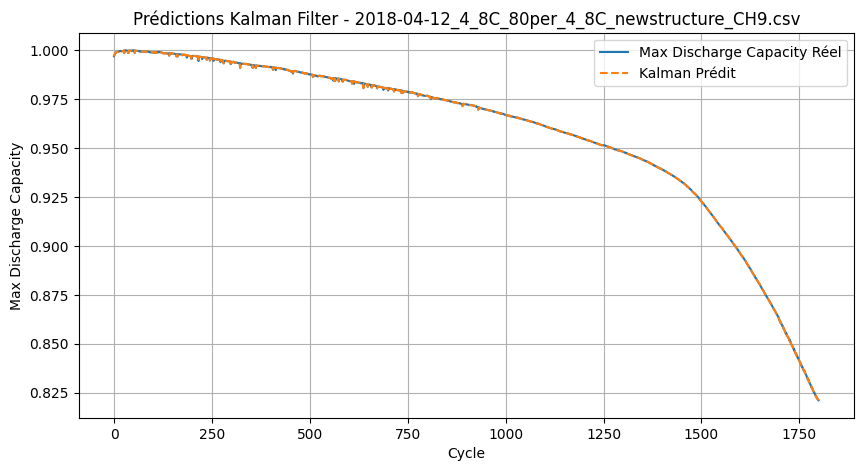

MSE moyen pour le modèle de Kalman: 0.00014222016143741577


In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.metrics import mean_squared_error

# Chemin vers le répertoire contenant les fichiers CSV
data_path = r'C:\\Users\\pc\\Desktop\\data\\all batchs'

# Lister tous les fichiers CSV dans le répertoire donné
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Sélectionner les fichiers pour l'entraînement et le test
train_files = csv_files[:12]  # Les 12 premiers fichiers pour l'entraînement
test_files = csv_files[12:]   # Les 5 derniers fichiers pour le test

# Fonction pour entraîner un filtre de Kalman sur les données de capacité de décharge
def train_kalman_filter(train_data):
    # Initialiser le filtre de Kalman avec une matrice de transition et d'observation simples
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
    kf = kf.em(train_data, n_iter=10)  # Utiliser l'Expectation Maximization pour ajuster les paramètres
    return kf

# Entraîner le filtre de Kalman sur les fichiers d'entraînement
y_train_total = []

for csv_file in train_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    y_train = df['Discharge_Capacity']
    y_train_total.append(y_train)

# Concaténer les données d'entraînement
y_train = pd.concat(y_train_total, axis=0).values

# Entraîner le filtre de Kalman sur les données de capacité de décharge
kf = train_kalman_filter(y_train.reshape(-1, 1))

# Tester le modèle de Kalman sur les fichiers de test
mse_list = []
for csv_file in test_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    y_test = df['Discharge_Capacity'].values
    cycle_index = df['Cycle_Index']

    # Utiliser le filtre de Kalman pour faire des prédictions
    kalman_pred, _ = kf.filter(y_test.reshape(-1, 1))

    # Calculer le MSE entre les vraies valeurs et les prédictions
    mse = mean_squared_error(y_test, kalman_pred)
    mse_list.append(mse)

    # Calculer le max discharge capacity par cycle
    y_test_max_per_cycle = df.groupby('Cycle_Index')['Discharge_Capacity'].max()
    kalman_pred_max_per_cycle = pd.Series(kalman_pred.flatten()).groupby(cycle_index).max()

    # Afficher les graphes pour chaque fichier
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_max_per_cycle.values, label='Max Discharge Capacity Réel')
    plt.plot(kalman_pred_max_per_cycle.values, label='Kalman Prédit', linestyle='--')
    plt.xlabel('Cycle')
    plt.ylabel('Max Discharge Capacity')
    plt.title(f'Prédictions Kalman Filter - {csv_file}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Afficher le MSE moyen sur les fichiers de test
print(f"MSE moyen pour le modèle de Kalman: {np.mean(mse_list)}")
